# Caradonna Tung Hover Rotor

This case aims to reproduce the results from an experiment undertaken by F. X. Caradonna and C. Tung in 1981 and published in NASA TM 81232.  The rotor airfoil section is a NACA0012 pitched about 25% chord. For this simulation the hub has been ignored.

This test case uses a moving (rotating) frame of reference to model the rotor.  

See the NASA Technical Report below, page 34. 

In [1]:
from IPython.display import FileLink, display 
display(FileLink('data/NASA_TM_81232.pdf')) 

/Users/David/Documents/zPost/ipynb/CARADONNA_TUNG/data/NASA_TM_81232.pdf

## Define Data Location
For remote data the interaction will use ssh to securely interact with the data<br/>
This uses the reverse connection capability in paraview so that the paraview server can be submitted to a job scheduler<br/>
Note: The default paraview server connection will use port 11111

In [2]:
remote_data = True
remote_server_auto = True

case_name = 'caratung-ar-6p0-pitch-8p0'
data_dir='/gpfs/thirdparty/zenotech/home/dstandingford/VALIDATION/CARATUNG'
data_host='dstandingford@vis03'
paraview_cmd='mpiexec /gpfs/cfms/apps/zCFD/bin/pvserver'

if not remote_server_auto:
    paraview_cmd=None

if not remote_data:
    data_host='localhost'
    paraview_cmd=None

## Validation and regression

In [3]:
# Validation for Caradonna Tung Rotor (Mach at Tip - 0.877) from NASA TM 81232, page 34
validate = True
regression = True
# Make movie option currently not working - TODO
make_movie = False

if (validate):
    valid = True
    validation_tol = 0.0100
    valid_lower_cl_0p50 = 0.2298-validation_tol
    valid_upper_cl_0p50 = 0.2298+validation_tol
    valid_lower_cl_0p68 = 0.2842-validation_tol
    valid_upper_cl_0p68 = 0.2842+validation_tol
    valid_lower_cl_0p80 = 0.2736-validation_tol
    valid_upper_cl_0p80 = 0.2736+validation_tol
    valid_lower_cl_0p89 = 0.2989-validation_tol
    valid_upper_cl_0p89 = 0.2989+validation_tol
    valid_lower_cl_0p96 = 0.3175-validation_tol
    valid_upper_cl_0p96 = 0.3175+validation_tol
    print 'VALIDATING CARADONNA TUNG CASE'
    
if (regression):
    print 'REGRESSION CARADONNA TUNG CASE'

VALIDATING CARADONNA TUNG CASE
REGRESSION CARADONNA TUNG CASE


### Initialise Environment

In [4]:
%pylab inline
from paraview.simple import *
paraview.simple._DisableFirstRenderCameraReset()
import pylab as pl

Populating the interactive namespace from numpy and matplotlib
paraview version 4.2.0-77-g31a1d2a


### Data Connection
This starts paraview server on remote host and connects

In [5]:
from zutil.post import pvserver_connect
if remote_data:
    pvserver_connect(data_host=data_host,data_dir=data_dir,paraview_cmd=paraview_cmd)

Testing passwordless ssh access
-> Passed
Attempting to find unused port
[dstandingford@vis03] Executing task 'run_uname'
[dstandingford@vis03] Executing task 'port_test'
Selected Port: 12001
Starting pvserver connect
[dstandingford@vis03] Executing task 'port_test'
Starting pvserver process
[dstandingford@vis03] Executing task 'pvserver'
[dstandingford@vis03] run: /bin/bash -l -c "cd /gpfs/thirdparty/zenotech/home/dstandingford/VALIDATION/CARATUNG && sleep 2;mpiexec /gpfs/cfms/apps/zCFD/bin/pvserver -rc --client-host=localhost -sp=12001"
[dstandingford@vis03] out: 
[dstandingford@vis03] out: 		   _____ ______ __  __  _____ 
[dstandingford@vis03] out: 		  / ____|  ____|  \/  |/ ____|
[dstandingford@vis03] out: 		 | |    | |__  | \  / | (___  
[dstandingford@vis03] out: 		 | |    |  __| | |\/| |\___ \ 
[dstandingford@vis03] out: 		 | |____| |    | |  | |____) |
[dstandingford@vis03] out: 		  \_____|_|    |_|  |_|_____/ 
[dstandingford@vis03] out: 
[dstandingford@vis03] out: ++++++++++++

## Get control dictionary

In [6]:
from zutil.post import get_case_parameters,print_html_parameters
parameters=get_case_parameters(case_name,data_host=data_host,data_dir=data_dir)
# print parameters

Get status file

In [7]:
from zutil.post import get_status_dict
status=get_status_dict(case_name,data_host=data_host,data_dir=data_dir)
num_procs = str(status['num processor'])

### Define test conditions

In [8]:
from IPython.display import HTML
HTML(print_html_parameters(parameters))
aspect_ratio = 6.0
Pitch = 8.0

In [9]:
from zutil.post import for_each
from zutil import rotate_vector
from zutil.post import get_csv_data

def plot_cp_profile(ax,file_root,span_loc,ax2):
    
    wall = PVDReader( FileName=file_root+'_wall.pvd' )
    wall.UpdatePipeline()
    
    point_data = CellDatatoPointData(Input=wall)
    point_data.PassCellData = 0
    point_data.UpdatePipeline()

    merged = MergeBlocks(Input=point_data)
    merged.UpdatePipeline()
    
    wall_slice = Slice(Input=merged, SliceType="Plane" )
    wall_slice.SliceType.Normal = [0.0,1.0,0.0]
    wall_slice.SliceType.Origin = [0, span_loc*aspect_ratio, 0]
    wall_slice.UpdatePipeline()
    
    sorted_line = PlotOnSortedLines(Input=wall_slice)
    sorted_line.UpdatePipeline()

    slice_client = servermanager.Fetch(sorted_line)
    for_each(slice_client,func=plot_array,axis=ax,span_loc=span_loc,axis2=ax2)

def plot_array(data_array,pts_array,**kwargs):
    ax = kwargs['axis']
    span_loc = kwargs['span_loc']
    ax2 = kwargs['axis2']
    data = []
    pos = []
    pos_y = []
    count = 0
    cp_array = data_array.GetPointData()['cp']
    for p in pts_array.GetPoints()[:,0]:
        cp = float(cp_array[count])
        # transform to local Cp
        cp = cp/(span_loc)**2
        data.append(cp)
        pt_x = pts_array.GetPoints()[count,0]
        pt_z = pts_array.GetPoints()[count,2]
        # rotate by -8 deg
        pt_rot = rotate_vector([pt_x,0.0,pt_z],-8.0,0.0)
        pt = pt_rot[0] + 0.25
        pos.append(pt)
        pos_y.append(pt_rot[2])
        count+=1 
    ax.plot(pos, data , color='g',linestyle='-',marker='None',label='zCFD')
    ax2.plot(pos, pos_y , color='grey',linestyle='-',marker='None',label='profile')
    
def plot_experiment(ax, filename):
    header = True
    remote = False
    # Note - this returns a pandas dataframe object
    df = get_csv_data(filename,True,False)
    x = []
    y = []
    for ind in range(0,len(df.index)-1):
        x.append(df[list(df.columns.values)[0]][ind])
        y.append(-df[list(df.columns.values)[1]][ind])   
    ax.scatter(x, y, color='grey', label='Experiment')    


## Cp Profile

<IPython.core.display.Javascript object>

0.000494511689285 -8.00899623583e-07 0.00163779388868


/Applications/paraview.app/Contents/Python/paraview/vtk/numpy_interface/dataset_adapter.py:126: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if array == None:


<IPython.core.display.Javascript object>

0.000916439088792 -3.12672040614e-06 0.00325734025965


<IPython.core.display.Javascript object>

0.00137985820173 -6.27502938499e-06 0.00516703129056


<IPython.core.display.Javascript object>

0.00156352910652 -6.3012227165e-06 0.0056326817094


<IPython.core.display.Javascript object>

0.00094334185514 -4.12058180821e-06 0.0028357696978


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

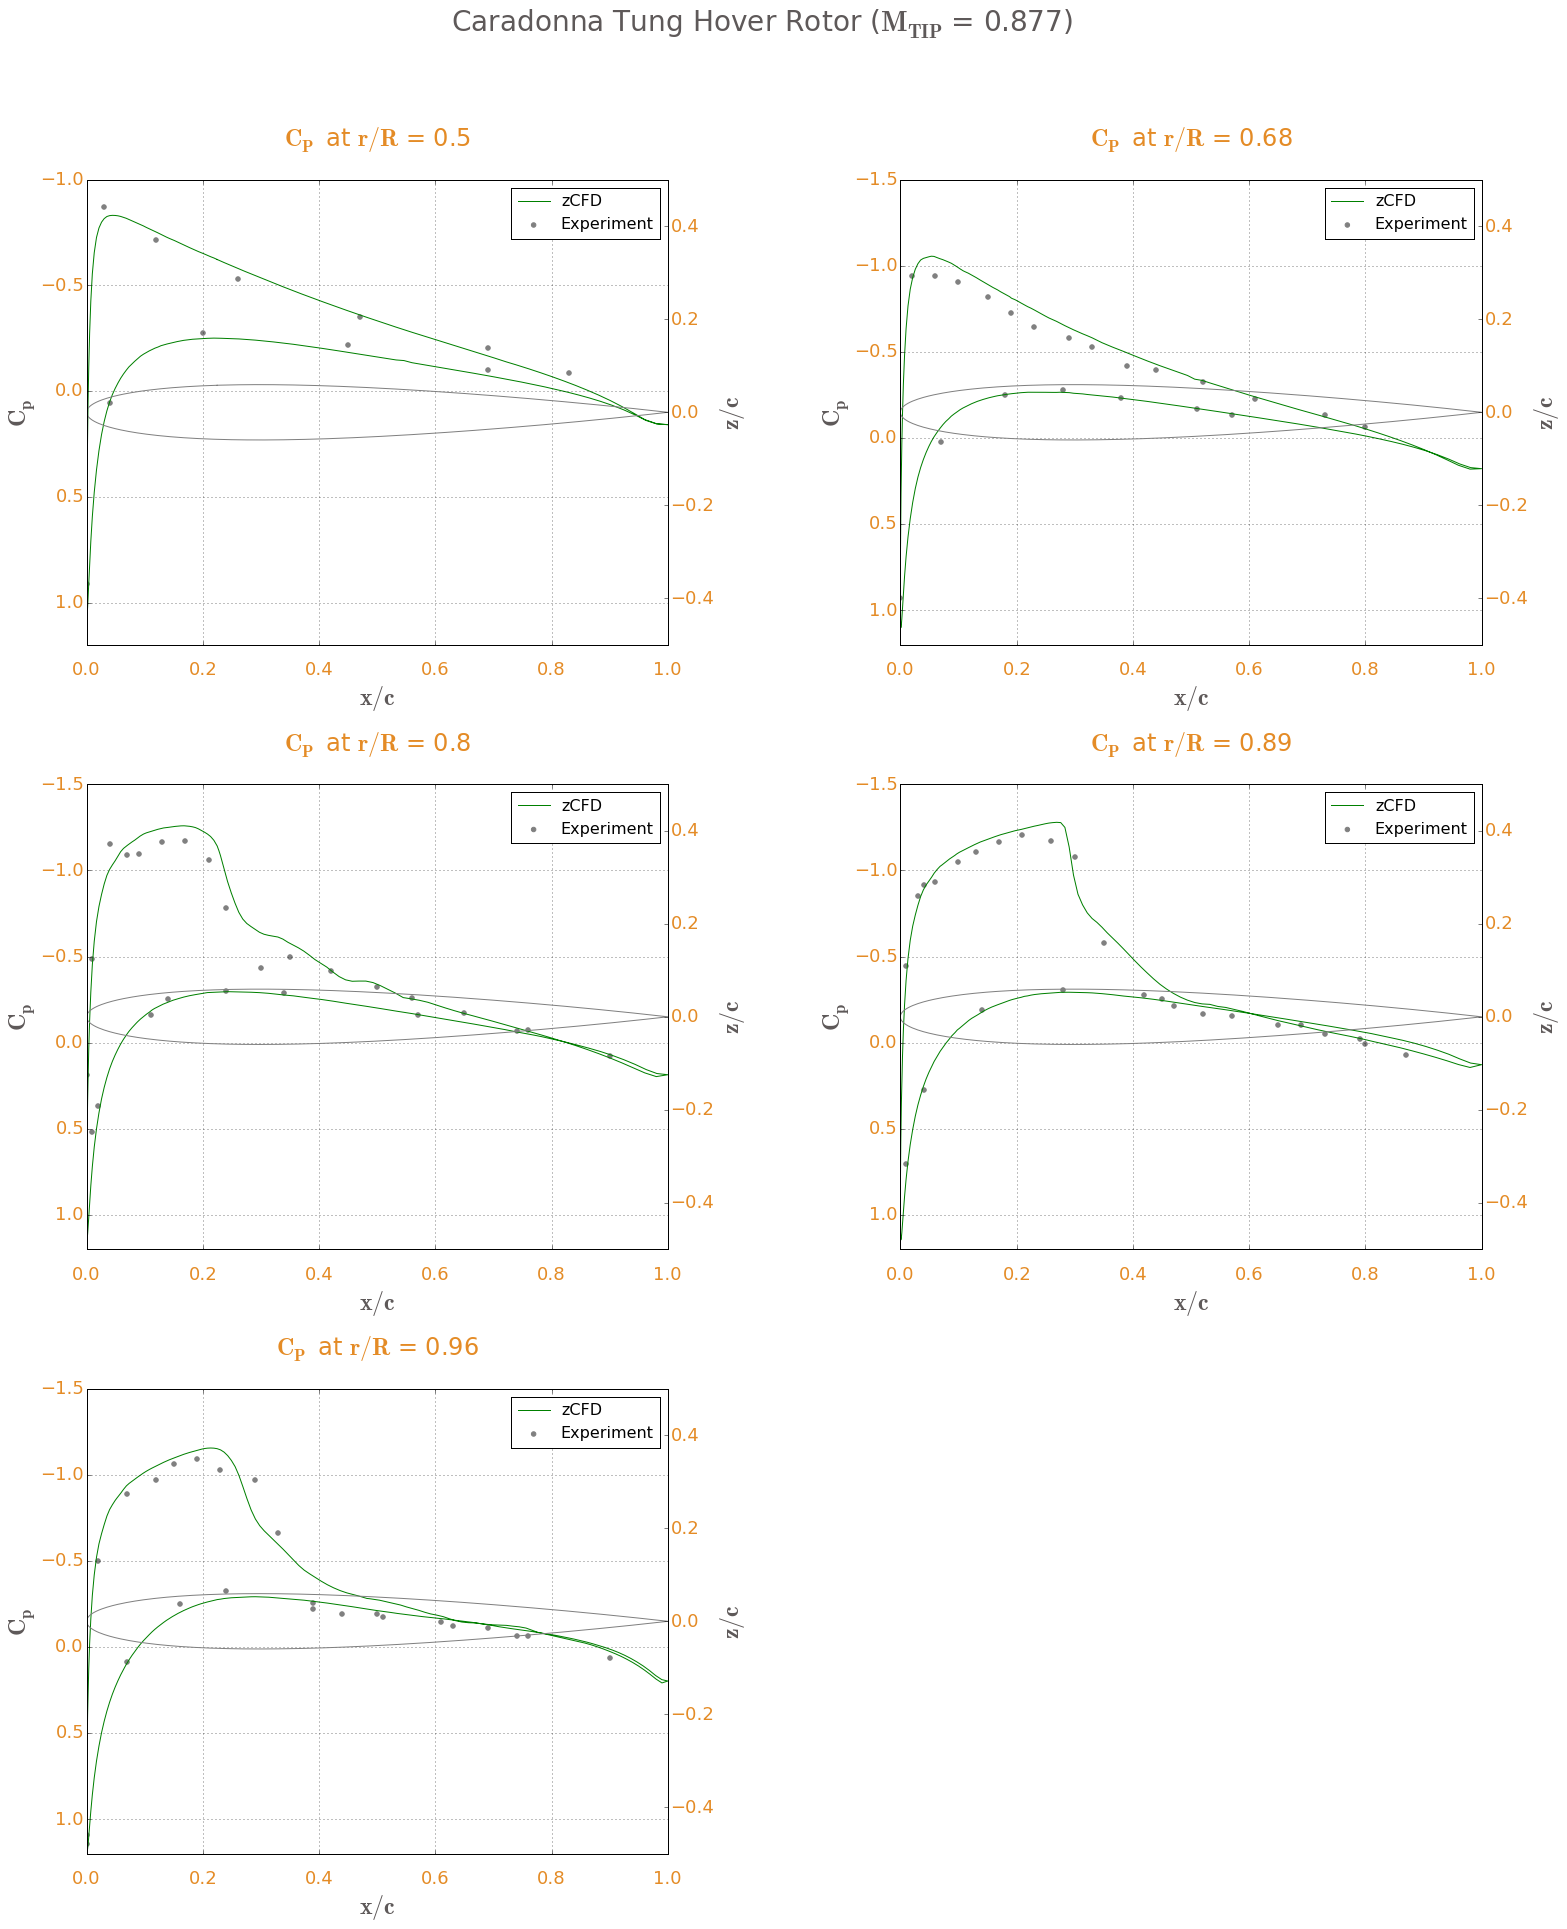

/Users/David/Documents/zPost/ipynb/CARADONNA_TUNG/images/Caradonna_Tung_CP_profile.png

In [10]:
from zutil.post import get_case_root, cp_profile_wall_from_file_span
from zutil.post import ProgressBar
from collections import OrderedDict

factor = 0.0
pbar = ProgressBar()

plot_list = OrderedDict([(0.50,{'exp_data_file': 'data/cp-0p50.txt', 'cp_axis':[0.0,1.0,1.2,-1.0]}),
                         (0.68,{'exp_data_file': 'data/cp-0p68.txt', 'cp_axis':[0.0,1.0,1.2,-1.5]}),
                         (0.80,{'exp_data_file': 'data/cp-0p80.txt', 'cp_axis':[0.0,1.0,1.2,-1.5]}),
                         (0.89,{'exp_data_file': 'data/cp-0p89.txt', 'cp_axis':[0.0,1.0,1.2,-1.5]}),
                         (0.96,{'exp_data_file': 'data/cp-0p96.txt', 'cp_axis':[0.0,1.0,1.2,-1.5]})])

fig = pl.figure(figsize=(25, 30),dpi=100, facecolor='w', edgecolor='k')
fig.suptitle('Caradonna Tung Hover Rotor (' + r'$\mathbf{M_{TIP}}$' + ' = 0.877)', 
             fontsize=28, fontweight='normal', color = '#5D5858')

pnum=1
cl = {}
for plot in plot_list:
    pbar+=5
    span_loc = plot + factor
    ax = fig.add_subplot(3,2,pnum)
    ax.set_title('$\mathbf{C_P}$' + ' at ' + '$\mathbf{r/R}$' + ' = ' + str(span_loc) + '\n', 
                 fontsize=24, fontweight='normal', color = '#E48B25')
    ax.grid(True)
    ax.set_xlabel('$\mathbf{x/c}$', fontsize=24, fontweight='bold', color = '#5D5858')
    ax.set_ylabel('$\mathbf{C_p}$', fontsize=24, fontweight='bold', color = '#5D5858')
    ax.axis(plot_list[plot]['cp_axis'])
    ax2 = ax.twinx()
    ax2.set_ylabel('$\mathbf{z/c}$', fontsize=24, fontweight='bold', color = '#5D5858')
    ax2.axis([0,1,-0.5,0.5])
    plot_cp_profile(ax,get_case_root(case_name,num_procs),span_loc,ax2)
    
    normal = [0.0, 1.0, 0.0]
    origin = [0.0, span_loc*aspect_ratio, 0.0]
    # Check this - alpha passed via kwargs to post.py
    # THESE NUMBERS ARE COMPLETELY WRONG - CHECK
    forces = cp_profile_wall_from_file_span(get_case_root(case_name,num_procs), normal, origin, alpha=Pitch)
    cd = forces['friction force'][0] + forces['pressure force'][0]
    cs = forces['friction force'][1] + forces['pressure force'][1]
    cl[plot] = forces['friction force'][2] + forces['pressure force'][2]
    print cd, cs, cl[plot]
    
    plot_experiment(ax,plot_list[plot]['exp_data_file'])
    ax.legend(loc='upper right', shadow=True)
    
    legend = ax.legend(loc='best', scatterpoints=1, numpoints=1, shadow=False, fontsize=16)
    legend.get_frame().set_facecolor('white')
    ax.tick_params(axis='x', pad=16)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        tick.label.set_fontweight('normal') 
        tick.label.set_color('#E48B25')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
        tick.label.set_fontweight('normal') 
        tick.label.set_color('#E48B25')
    for tick in ax2.yaxis.get_major_ticks():
        tick.label2.set_fontsize(18)
        tick.label2.set_fontweight('normal') 
        tick.label2.set_color('#E48B25') 
    
    pnum=pnum+1

fig.subplots_adjust(hspace=0.3) 
fig.subplots_adjust(wspace=0.4) 
fig.savefig("images/Caradonna_Tung_CP_profile.png")
pbar.complete()
show()
from IPython.display import FileLink, display 
display(FileLink('images/Caradonna_Tung_CP_profile.png'))

## Convergence

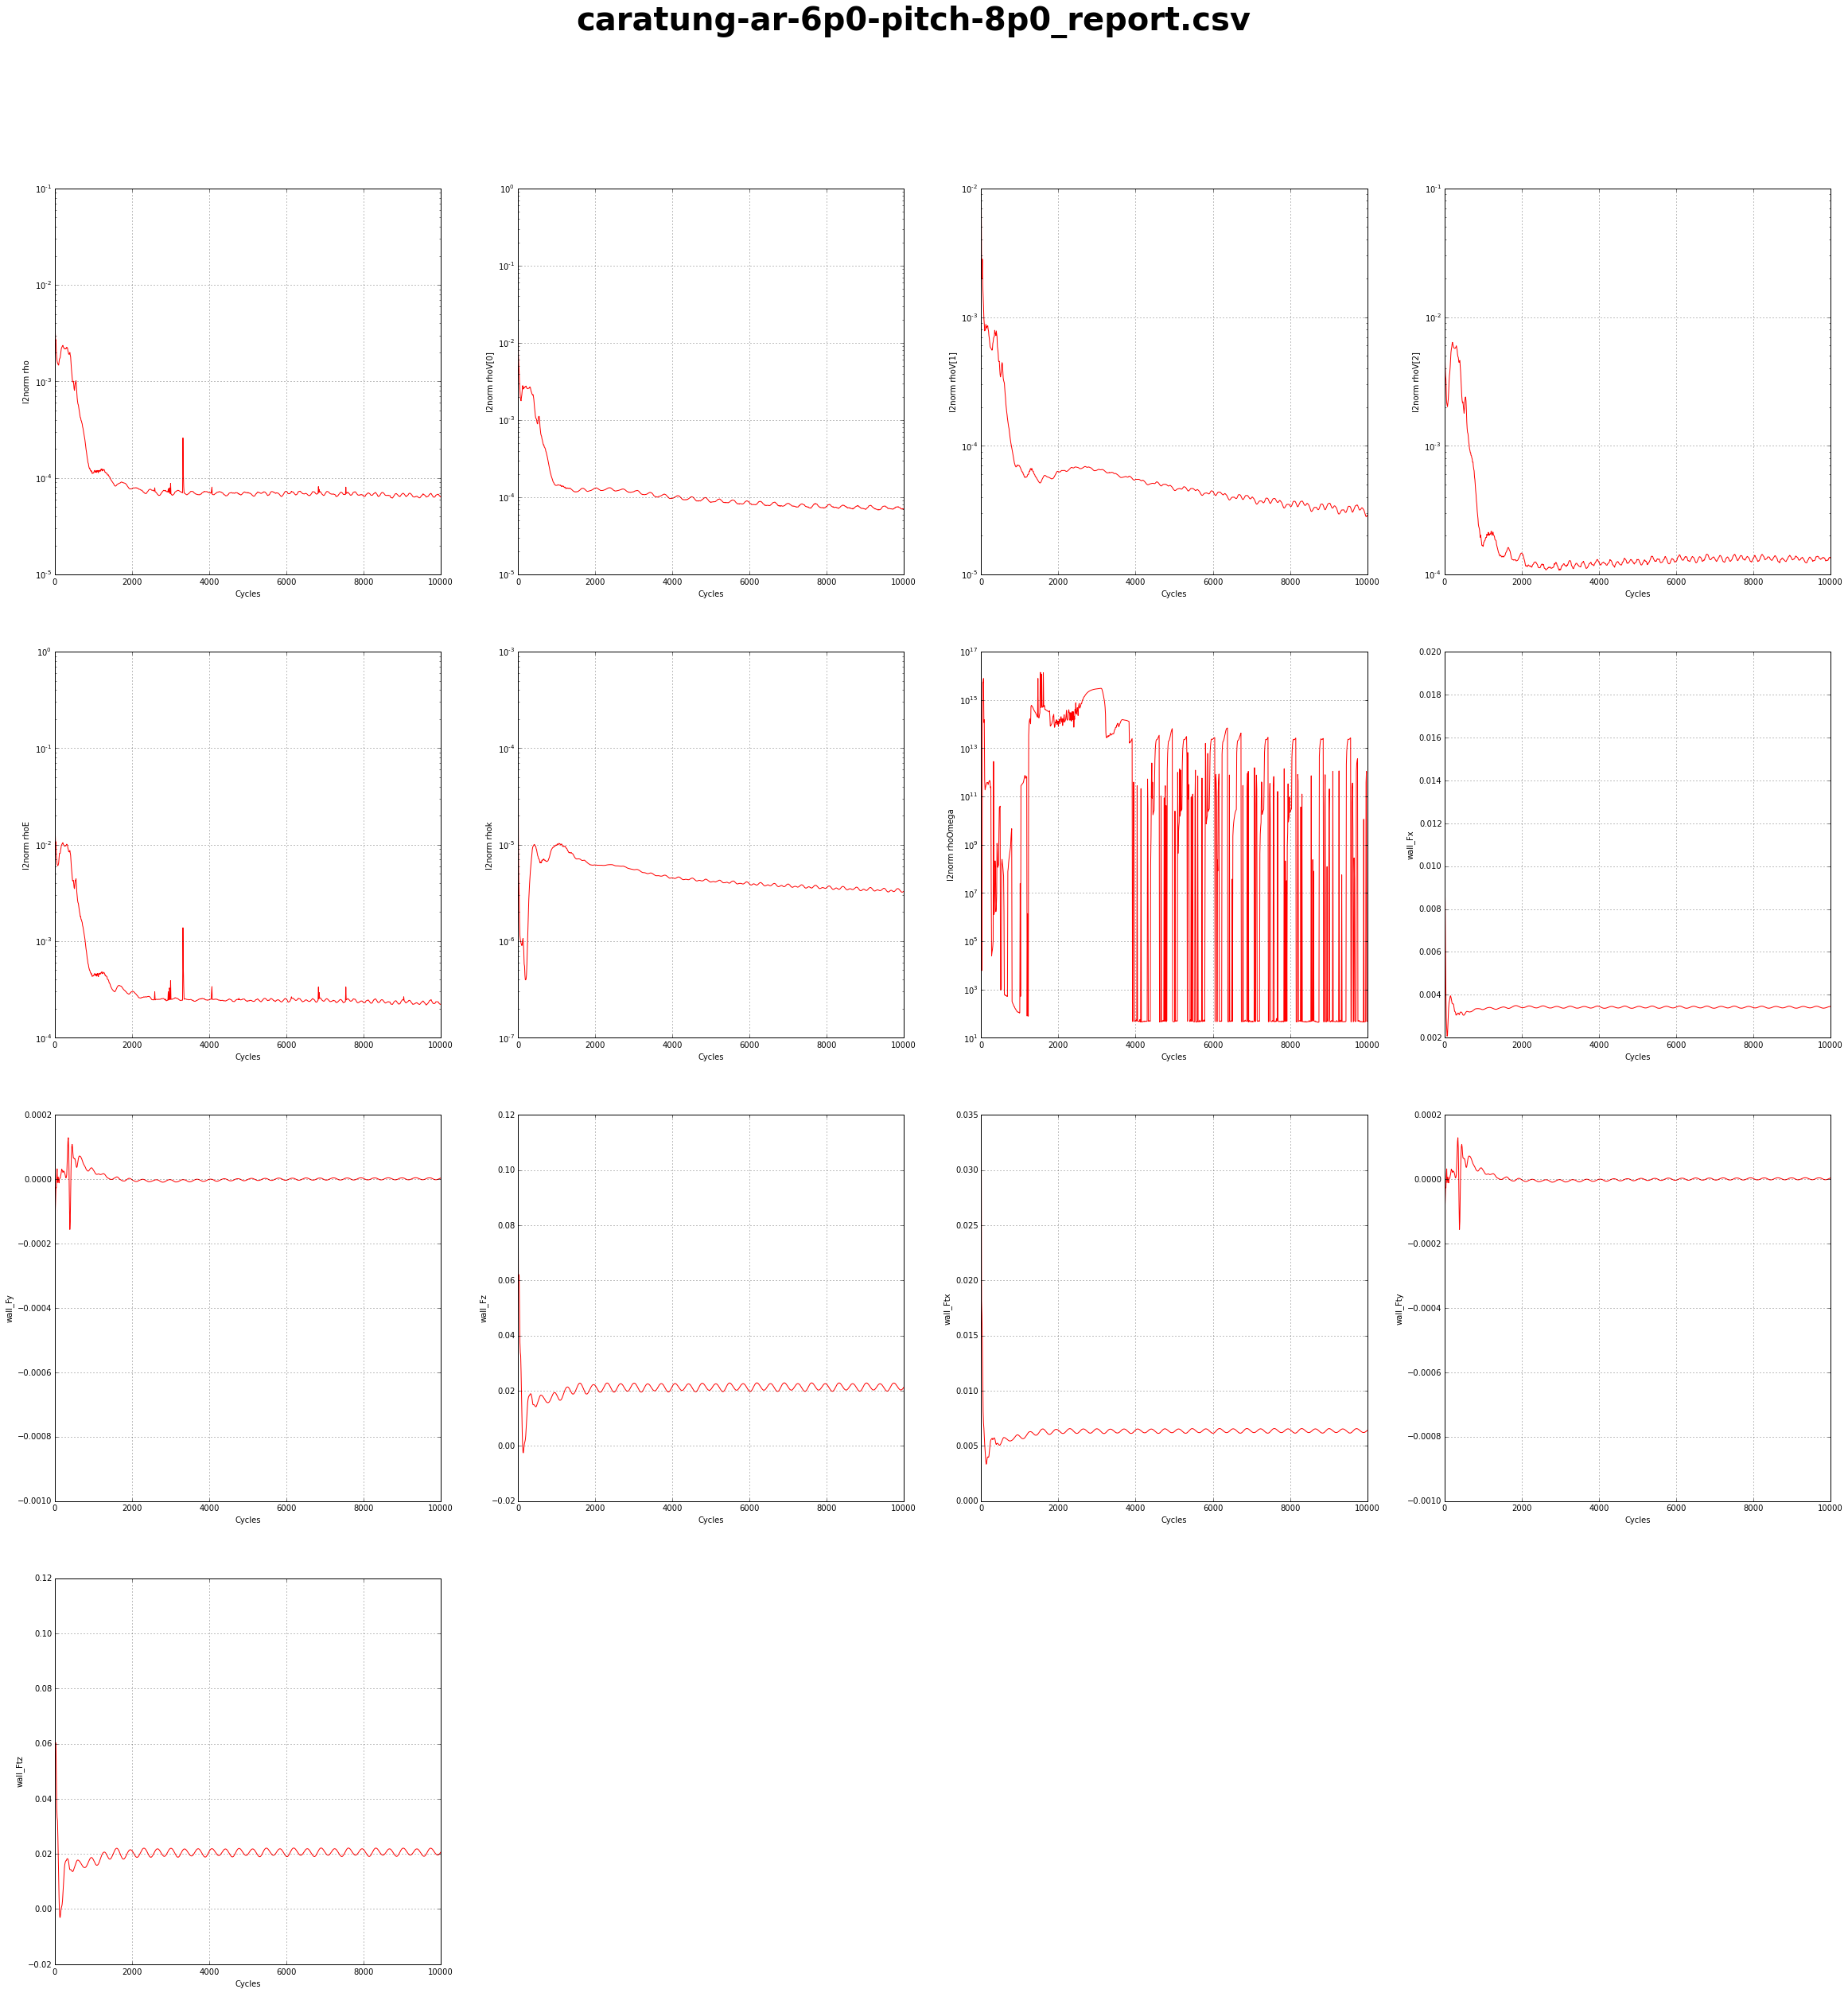

In [11]:
from zutil.post import residual_plot, get_case_report
residual_plot(get_case_report(case_name))
show()

In [12]:
if make_movie:
    from zutil.post import get_case_root
    from zutil.post import ProgressBar
    pb = ProgressBar()
    vtu = PVDReader( FileName=[get_case_root(case_name,num_procs)+'.pvd'] )
    vtu.UpdatePipeline()
    pb += 20
    merged = CleantoGrid(Input=vtu)
    merged.UpdatePipeline()
    pb += 20
    point_data = CellDatatoPointData(Input=merged)
    point_data.PassCellData = 0
    point_data.PieceInvariant = 1
    point_data.UpdatePipeline()
    pb.complete()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
if make_movie:
#    from paraview.vtk.dataset_adapter import DataSet
    from vtk.numpy_interface.dataset_adapter import DataSet
    stream = StreamTracer(Input=point_data)
    stream.SeedType = "Point Source"
    stream.SeedType.Center = [49673.0, 58826.0, 1120.0]
    stream.SeedType.Radius = 1
    stream.SeedType.NumberOfPoints = 1
    stream.Vectors = ['POINTS', 'V']
    stream.MaximumStreamlineLength = 135800.00000000035
    # IntegrationDirection can be FORWARD, BACKWARD, or BOTH
    stream.IntegrationDirection = 'BACKWARD'
    stream.UpdatePipeline()
    stream_client = servermanager.Fetch(stream)
    upstream_data = DataSet(stream_client)
    stream.IntegrationDirection = 'FORWARD'
    stream.UpdatePipeline()
    stream_client = servermanager.Fetch(stream)
    downstream_data = DataSet(stream_client)

In [ ]:
if make_movie:
    def vtk_show(renderer, w=100, h=100):
        """
        Takes vtkRenderer instance and returns an IPython Image with the rendering.
        """
        from vtk import vtkRenderWindow,vtkWindowToImageFilter,vtkPNGWriter
    
        renderWindow = vtkRenderWindow()
        renderWindow.SetOffScreenRendering(1)
        renderWindow.AddRenderer(renderer)
        renderWindow.SetSize(w, h)
        renderWindow.Render()
     
        windowToImageFilter = vtkWindowToImageFilter()
        windowToImageFilter.SetInput(renderWindow)
        windowToImageFilter.Update()
     
        writer = vtkPNGWriter()
        writer.SetWriteToMemory(1)
        writer.SetInputConnection(windowToImageFilter.GetOutputPort())
        writer.Write()
        data = str(buffer(writer.GetResult()))
    
        from IPython.display import Image
        return Image(data)



In [ ]:
if make_movie:
    #print stream_data.GetPoint(0)
    from zutil.post import ProgressBar
    pb = ProgressBar()

    wall = PVDReader( FileName=[get_case_root(case_name,num_procs)+'_wall.pvd'] )
    wall.UpdatePipeline()

    merged = CleantoGrid(Input=wall)
    merged.UpdatePipeline()

    point_data = CellDatatoPointData(Input=merged)
    point_data.PassCellData = 0
    point_data.PieceInvariant = 1
    point_data.UpdatePipeline()

    total_pts = 100# stream_data.GetNumberOfPoints()

    scene = GetAnimationScene()
    scene.EndTime = total_pts
    scene.PlayMode = 'Snap To TimeSteps'
    scene.AnimationTime = 0

    a1_yplus_PVLookupTable = GetLookupTableForArray( "yplus", 1, RGBPoints=[96.69050598144531, 0.23, 0.299, 0.754, 24391.206581115723, 0.865, 0.865, 0.865, 48685.72265625, 0.706, 0.016, 0.15], VectorMode='Magnitude', NanColor=[0.25, 0.0, 0.0], ColorSpace='Diverging', ScalarRangeInitialized=1.0 )
    a1_yplus_PiecewiseFunction = CreatePiecewiseFunction( Points=[96.69050598144531, 0.0, 0.5, 0.0, 48685.72265625, 1.0, 0.5, 0.0] )

    drepr = Show() # GetDisplayProperties( Contour1 )
    drepr.EdgeColor = [0.0, 0.0, 0.5000076295109483]
    drepr.SelectionPointFieldDataArrayName = 'yplus'
    #DataRepresentation4.SelectionCellFieldDataArrayName = 'eddy'
    drepr.ColorArrayName = ('POINT_DATA', 'yplus')
    drepr.LookupTable = a1_yplus_PVLookupTable
    drepr.ScaleFactor = 0.08385616838932038
    drepr.Interpolation = 'Flat'
    drepr.ScalarOpacityFunction = a1_yplus_PiecewiseFunction

    view = GetRenderView()
    if not view:
        # When using the ParaView UI, the View will be present, not otherwise.
        view = CreateRenderView()

    scene.ViewModules = [view]

    view.CameraViewUp = [0.0, 0.0, 1.0]
    view.CameraPosition = list(upstream_data.GetPoint(0))
    view.CameraFocalPoint = list(upstream_data.GetPoint(1))
    view.CameraParallelScale = 0.499418869125992
    view.CenterOfRotation = [49673.0, 58826.0, 1120.0]
    view.CenterAxesVisibility = 0
    view.ViewSize = [3840,2160]
    view.LightSwitch=0
    view.UseLight = 1
    #RenderView2.SetOffScreenRendering(1)
    #Render()

    pb+=20

    camera = view.GetActiveCamera()
    key_frames = []
    for p in range(total_pts):
        pt =  stream_data.GetPoint(p)
        #print pt
        frame = CameraKeyFrame()
        frame.Position = list(pt)
        frame.ViewUp = [0.0, 0.0, 1.0]
        frame.FocalPoint = camera.GetFocalPoint()
        frame.KeyTime = p/total_pts
        key_frames.append(frame)

    pb+=20
    
    cue = GetCameraTrack()
    cue.Mode = 'Interpolate Camera'
    cue.AnimatedProxy = view
    cue.KeyFrames = key_frames

    TimeAnimationCue4 = GetTimeTrack()

    scene.Cues = [cue]

    for t in range(total_pts-1):
        print 'Generating: ' + str(t)
        pt =  stream_data.GetPoint(t)
        view.CameraPosition = list(pt)
        view.CameraFocalPoint = list(stream_data.GetPoint(t+1))
        #vtk_show(view.GetRenderer())
        Render()
        #scene.AnimationTime = t
        WriteImage('movies/caradonna_'+str(t)+'.png')
        
    pb.complete()

## Check validation and regression¶

In [ ]:
if (validate):
    def validate_data(name, value, valid_lower, valid_upper):
        if ((value < valid_lower) or (value > valid_upper)):
            print 'INVALID: ' + name + ' %.4f '%valid_lower + '%.4f '%value + ' %.4f'%valid_upper
            return False
        else:
            return True  
        
    valid = validate_data('C_L[0.50]', cl[0.50], valid_lower_cl_0p50, valid_upper_cl_0p50) and valid
    valid = validate_data('C_L[0.68]', cl[0.68], valid_lower_cl_0p68, valid_upper_cl_0p68) and valid
    valid = validate_data('C_L[0.80]', cl[0.80], valid_lower_cl_0p80, valid_upper_cl_0p80) and valid
    valid = validate_data('C_L[0.89]', cl[0.89], valid_lower_cl_0p89, valid_upper_cl_0p89) and valid
    valid = validate_data('C_L[0.96]', cl[0.96], valid_lower_cl_0p96, valid_upper_cl_0p96) and valid
    
    if (valid):
        print 'VALIDATION = PASS :-)'
    else:
        print 'VALIDATION = FAIL :-('   

In [ ]:
if (regression):
    import pandas as pd
    pd.options.display.float_format = '{:,.6f}'.format
    print 'REGRESSION DATA'
    regress = {'version' : ['v0.0', 'v0.1'  , 'CURRENT'], 
               'C_L[0.50]' : [2.217000, 2.217000, cl[0.50]], 
               'C_L[0.68]' : [0.497464, 0.498132, cl[0.68]],
               'C_L[0.80]' : [0.024460, 0.024495, cl[0.80]],
               'C_L[0.89]' : [0.014094, 0.014099, cl[0.89]],
               'C_L[0.96]' : [0.010366, 0.010396, cl[0.96]]}
    regression_table = pd.DataFrame(regress, columns=['version','C_L[0.50]','C_L[0.68]',
                                                      'C_L[0.80]','C_L[0.89]','C_L[0.96]'])
    print regression_table

### Cleaning up

In [ ]:
if remote_data:
    #print 'Disconnecting from remote paraview server connection'
    Disconnect()